In [12]:
import os
import random
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.applications import resnet50
from PIL.ImageDraw import Draw
import torch.nn as nn
from torchvision import transforms
from keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from time import process_time

In [13]:
import kagglehub
path = kagglehub.dataset_download("fmena14/crowd-counting")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/crowd-counting


In [14]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 14})

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.4f}'.format

In [15]:
META_FILE = '../input/crowd-counting/labels.csv'
data = pd.read_csv(META_FILE)
data.head()

,id,count
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41


In [16]:
def reconstruct_path(image_id):
    image_id = str(image_id).rjust(6, '0')
    return f'../input/crowd-counting/frames/frames/seq_{image_id}.jpg'


data['path'] = data['id'].apply(reconstruct_path)
data.head()

,id,count,path
0,1,35,../input/crowd-counting/frames/frames/seq_0000...
1,2,41,../input/crowd-counting/frames/frames/seq_0000...
2,3,41,../input/crowd-counting/frames/frames/seq_0000...
3,4,44,../input/crowd-counting/frames/frames/seq_0000...
4,5,41,../input/crowd-counting/frames/frames/seq_0000...


In [17]:
data.describe()

,id,count
count,2000.0000,2000.0000
mean,1000.5000,31.1575
std,577.4946,6.9454
min,1.0000,13.0000
25%,500.7500,26.0000
50%,1000.5000,31.0000
75%,1500.2500,36.0000
max,2000.0000,53.0000


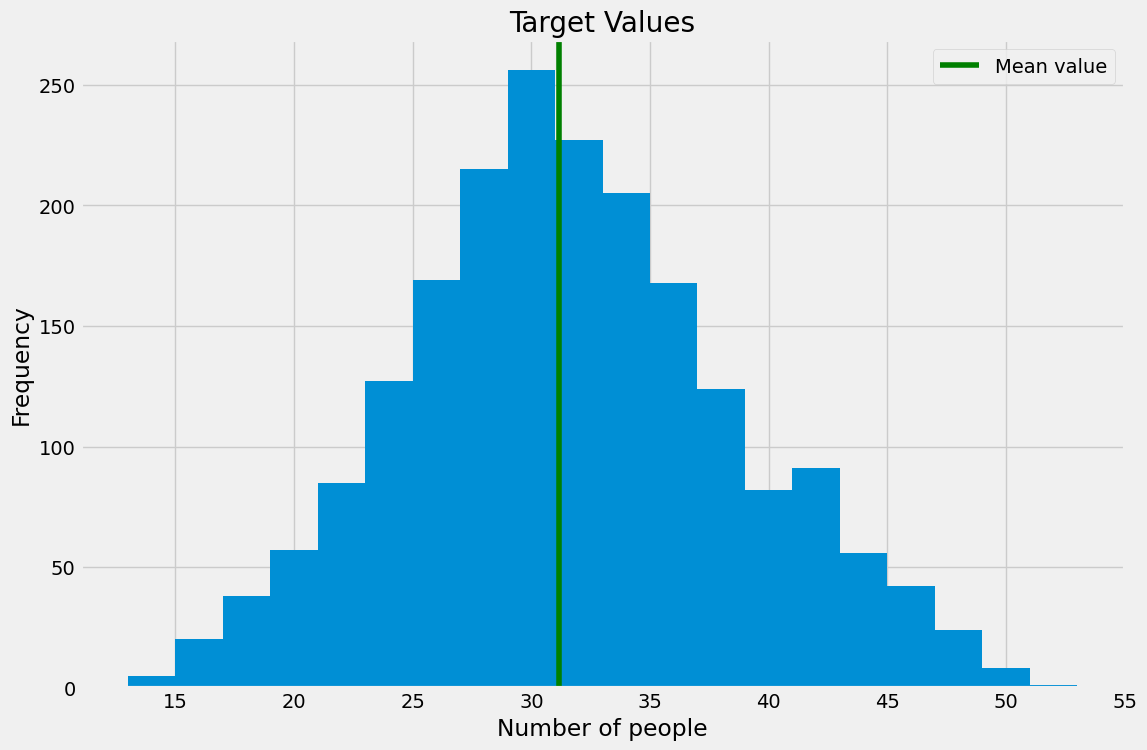

In [18]:
plt.hist(data['count'], bins=20)
plt.axvline(data.describe().loc['mean', 'count'], label='Mean value', color='green')
plt.legend()
plt.xlabel('Number of people')
plt.ylabel('Frequency')
plt.title('Target Values')
plt.show()

In [19]:
import os
print(os.path.exists("/kaggle/input/resnet50_weights.h5/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"))


True


In [20]:
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(
    weights="/kaggle/input/resnet50_weights.h5/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
    include_top=False,
    input_shape=(224, 224, 3),
    pooling="avg"
)


In [21]:
x = resnet.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='linear')(x)
rn_model = tf.keras.Model(inputs=resnet.input, outputs=predictions)

In [22]:
rn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss="mean_squared_error",
    metrics=['mean_absolute_error', 'mean_squared_error']
)

In [23]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=resnet50.preprocess_input,
)

In [24]:
flow_params = dict(
    dataframe=data,
    x_col='path',
    y_col='count',
    weight_col=None,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    batch_size=4,
    shuffle=True,
    seed=0,
)

train_generator = datagen.flow_from_dataframe(
    subset='training',
    **flow_params    
)
valid_generator = datagen.flow_from_dataframe(
    subset='validation',
    **flow_params
)

Found 1600 validated image filenames.
Found 400 validated image filenames.


In [25]:
for layer in rn_model.layers[:-7]:
    layer.trainable = False
for layer in rn_model.layers[-7:]:
    layer.trainable = True

In [26]:
start = time.process_time()
history = rn_model.fit(train_generator, epochs=50, validation_data=valid_generator, verbose=2, ) 
end = time.process_time()
rn_time = round(end - start, 2)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


400/400 - 26s - 66ms/step - loss: 44.5913 - mean_absolute_error: 5.1879 - mean_squared_error: 44.5913 - val_loss: 298.3402 - val_mean_absolute_error: 16.5222 - val_mean_squared_error: 298.3402
Epoch 2/50
400/400 - 7s - 18ms/step - loss: 34.4038 - mean_absolute_error: 4.7200 - mean_squared_error: 34.4038 - val_loss: 43.6069 - val_mean_absolute_error: 5.4636 - val_mean_squared_error: 43.6069
Epoch 3/50
400/400 - 8s - 19ms/step - loss: 29.9801 - mean_absolute_error: 4.3813 - mean_squared_error: 29.9801 - val_loss: 36.1596 - val_mean_absolute_error: 4.9320 - val_mean_squared_error: 36.1596
Epoch 4/50
400/400 - 8s - 19ms/step - loss: 28.4440 - mean_absolute_error: 4.2551 - mean_squared_error: 28.4440 - val_loss: 107.3218 - val_mean_absolute_error: 9.3774 - val_mean_squared_error: 107.3218
Epoch 5/50
400/400 - 8s - 20ms/step - loss: 28.4767 - mean_absolute_error: 4.2254 - mean_squared_error: 28.4767 - val_loss: 21.0622 - val_mean_absolute_error: 3.6776 - val_mean_squared_error: 21.0622
Epoch

In [27]:
def plot_history(hist):
    mae = hist.history['mean_absolute_error']
    val_mae = hist.history['val_mean_absolute_error']
    x_axis = range(1, len(mae) + 1)
    plt.plot(x_axis, mae, 'bo', label='Training')
    plt.plot(x_axis, val_mae, 'ro', label='Validation')
    plt.title('MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

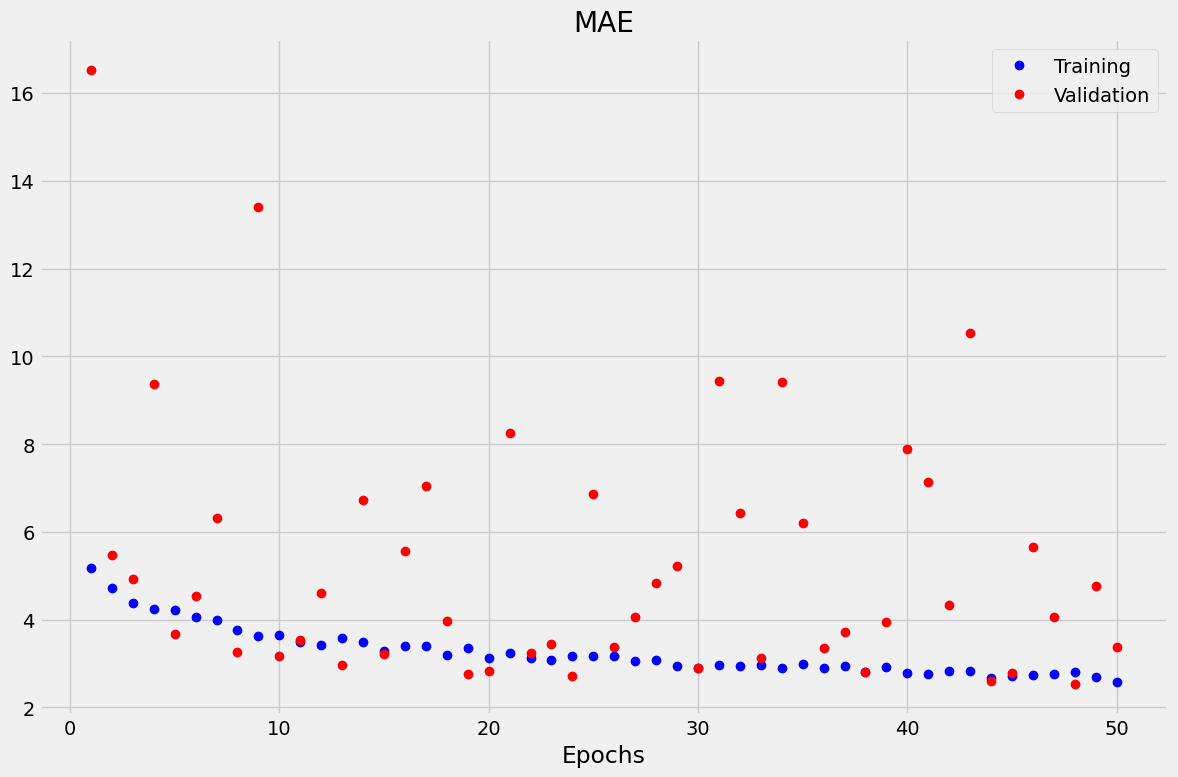

In [28]:
plot_history(history)

In [29]:
mae_rn = history.history['mean_absolute_error'][49]
mse_rn = history.history['mean_squared_error'][49]
print(f'Validation MSE = {mse_rn}\n'
      f'Validation MAE = {mae_rn}')

Validation MSE = 10.793164253234863
Validation MAE = 2.589935064315796


In [30]:
def detect_objects(path, model):
    """Extracts the image from the file, adds a new axis and applies the model to the object..
    """
    image_tensor = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[tf.newaxis, ...]
    return model(image_tensor)


def count_persons(path, model, threshold=0.):
    """Considers the number of people in the image.
    """
    results = detect_objects(path, model)
    return (results['detection_classes'].numpy()[0] == 1)[np.where(
        results['detection_scores'].numpy()[0] > threshold)].sum()

def draw_boxes(image_path, data, threshold=0.):
    """Returns images with rectangles on top of each detected person.
    """
    image = PIL.Image.open(image_path)
    # Resize the image to 224x224
    img = img.resize((224, 224))
    
    # Convert image to numpy array and add a batch dimension
    img = np.expand_dims(np.array(img), axis=0)
    draw = Draw(image)

    im_width, im_height = image.size

    boxes = data['detection_boxes'].numpy()[0]
    classes = data['detection_classes'].numpy()[0]
    scores = data['detection_scores'].numpy()[0]

    for i in range(int(data['num_detections'][0])):
        if classes[i] == 1 and scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                      width=4, fill='red')

    return image

In [32]:
from PIL import Image
import numpy as np

example_path = '../input/crowd-counting/frames/frames/seq_000010.jpg'

# Load the image
img = Image.open(example_path) 
img_array = np.array(img)  

# Check the shape
print(img_array.shape)  


(480, 640, 3)


In [34]:
from PIL import Image
example_path = '../input/crowd-counting/frames/frames/seq_000010.jpg'
import tensorflow as tf

def detect_objects(path, model):
    image_tensor = tf.io.read_file(path)
    image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
    image_tensor = tf.image.resize(image_tensor, (224, 224))  # Resize to match ResNet50 input
    image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension
    image_tensor = image_tensor / 255.0  # Normalize if required

    return model(image_tensor)

# Test the function
results = detect_objects(example_path, rn_model)
print("Detection Results:", results)


Detection Results: tf.Tensor([[29.495144]], shape=(1, 1), dtype=float32)
